In [25]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [26]:
import matplotlib as mp

In [27]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [28]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, and_, distinct

In [29]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [30]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [31]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [32]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [33]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [34]:
# Display the row's columns and data in dictionary format
Station_first_row = session.query(Station).first()
Station_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1472cd1e0>,
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0,
 'longitude': -157.8168,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US'}

In [35]:
# Display the row's columns and data in dictionary format
Measurement_first_row = session.query(Measurement).first()
Measurement_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1472cf760>,
 'id': 1,
 'prcp': 0.08,
 'tobs': 65.0,
 'station': 'USC00519397',
 'date': '2010-01-01'}

# Exploratory Precipitation Analysis

In [36]:
# Find the most recent date in the data set.
earliest_date = session.query(Measurement.date).order_by(Measurement.date).first()
print(earliest_date)

('2010-01-01',)


In [37]:
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(latest_date)
# parsed_datetime = dt.strptime(latest_date, "%Y-%m-%d %H:%M:%S")
# print(parsed_datetime)

('2017-08-23',)


In [38]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
# Calculate the date one year from the last date in data set.
start_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(start_date)


2016-08-23


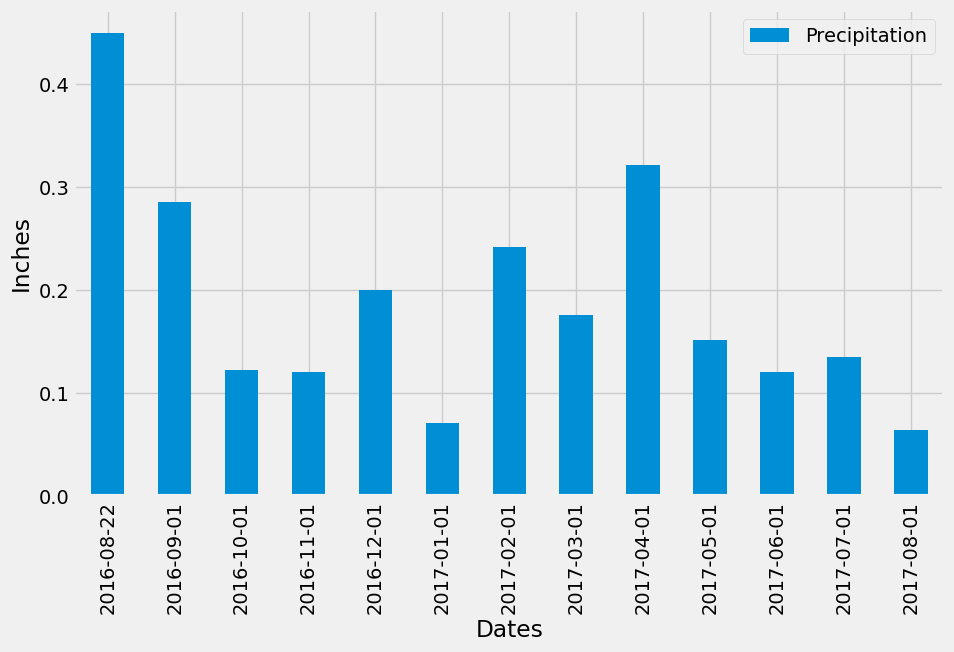

In [39]:
# # Perform a query to retrieve the data and precipitation scores HINT: Don't pass the date as a variable to your query
measurements = (
    session.query(Measurement.date, func.avg(Measurement.prcp).label('avg_prcp'))
    .filter(Measurement.date.between(dt.date(2016, 8, 22), dt.date(2017, 8, 24)))
    .group_by(func.strftime('%Y-%m', Measurement.date))
    .all()
)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
measurements_df = pd.DataFrame(measurements, columns=['Dates', 'Precipitation'])

# Sort the dataframe by date
measurements_df.sort_values('Dates', ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
measurements_df.set_index('Dates', inplace=True)
plot = measurements_df.plot(kind='bar', ylabel='Inches', figsize=(10, 6))


plt.show()


In [40]:
# Use Pandas to calculate the summary statistics for the precipitation data
stats = measurements_df['Precipitation'].describe()
stats

count    13.000000
mean      0.188785
std       0.110212
min       0.063951
25%       0.120234
50%       0.151317
75%       0.241111
max       0.449483
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [41]:
# Design a query to calculate the total number of stations in the dataset
stations = (
    session.query(distinct(Station.name)).all()
)
stations_list = [result[0] for result in stations]
#print(stations_list)
number_of_unique_stations = len(stations_list)
number_of_unique_stations

9

In [42]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# Query to find the most active stations
most_active_stations = (
    session.query(Measurement.station, func.count(Measurement.station).label('station_count'))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)

# List the stations and their counts in descending order.
for station, count in most_active_stations:
    print(f"Station {station}: {count} rows")

Station USC00519281: 2772 rows
Station USC00519397: 2724 rows
Station USC00513117: 2709 rows
Station USC00519523: 2669 rows
Station USC00516128: 2612 rows
Station USC00514830: 2202 rows
Station USC00511918: 1979 rows
Station USC00517948: 1372 rows
Station USC00518838: 511 rows


In [43]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_statistics = (
    session.query(func.min(Measurement.tobs).label('lowest_temp'),
                  func.max(Measurement.tobs).label('highest_temp'),
                  func.avg(Measurement.tobs).label('average_temp')
                 )
    .filter(Measurement.station == 'USC00519281')
    .first()
)
lowest_temp, highest_temp, average_temp = temp_statistics
print(f"Lowest Temp: {lowest_temp}")
print(f"Highest Temp: {highest_temp}")
print(f"Average temp: {average_temp}")

Lowest Temp: 54.0
Highest Temp: 85.0
Average temp: 71.66378066378067


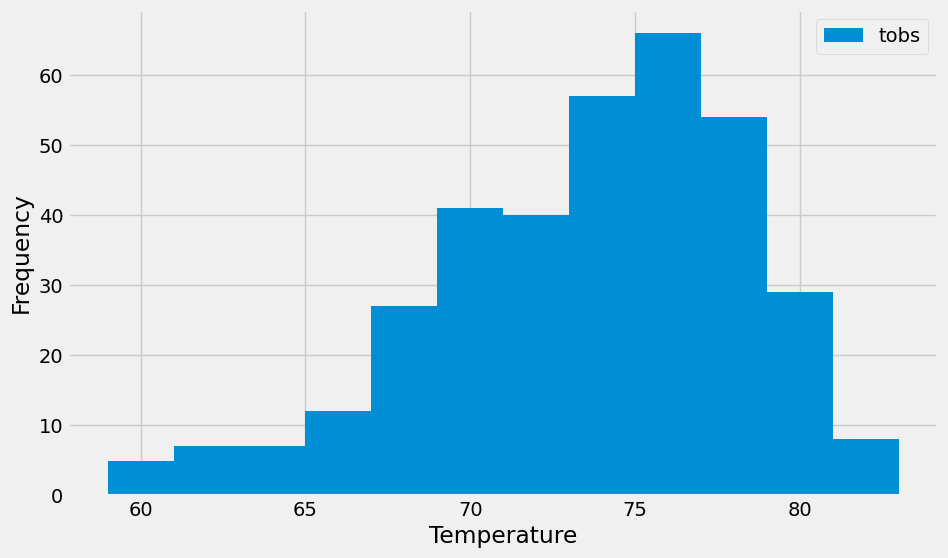

In [44]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == 'USC00519281')
    .filter(Measurement.date >= dt.date(2016, 8, 22))
    .all()
)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
temp_obs_df = pd.DataFrame(temp_obs, columns=['tobs'])


# Use Pandas Plotting with Matplotlib to plot the data
plot = temp_obs_df.plot(kind='hist', bins=12, xlabel='Temperature', ylabel='Frequency', figsize=(10, 6))


plt.show()

# Close Session

In [45]:
# Close Session
session.close()